In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # from .../CitationRetrieval/server to .../CitationRetrieval
sys.path.insert(0, str(PROJECT_ROOT))

In [ ]:
# orchestrator.py
"""
LangGraph workflow with conditional routing for self-evolution.

When evolution is enabled, the workflow uses conditional edges to route
to optimized versions of the reformulator and picker nodes.
"""

import logging
import os
from pathlib import Path
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END



# Load environment variables
load_dotenv()

logger = logging.getLogger(__name__)

# Import Retriever agent functions
from src.agents.retrievers.bm25_agent import bm25_agent
from src.agents.retrievers.e5_agent import e5_agent
from src.agents.retrievers.specter_agent import specter_agent

# Import Formulator agent functions (default and optimized versions)
from src.agents.formulators.query_reformulator import (
    query_reformulator,
)
from src.agents.formulators.aggregator import aggregator
from src.agents.formulators.llm_agent import llm_reranker
from src.agents.formulators.dspy_picker import dspy_picker
from src.models.state import RetrievalState


class RetrievalWorkflow:
    def __init__(self, use_llm_reranker: bool = False, enable_evolution: bool = False):
        """
        Initialize the workflow and build the graph pipeline.

        Args:
            use_llm_reranker: If True, use LLM reranker instead of cross-encoder reranker
            enable_evolution: If True, enable DSPy self-evolution features with conditional routing
        """
        self.use_llm_reranker = use_llm_reranker
        self.pipeline = self._build_workflow()

    def evaluator(self, state: RetrievalState) -> bool:
        pass
    
    def _needs_optimization(self, state: RetrievalState) -> bool:
        """Check if the LLM-Reranking needs optimization."""
        return state.get("needs_optimization", False)
    
    def _optimization_viewer(self, state: RetrievalState) -> None:
        pass

    def _apply_prompt_update(self, state: RetrievalState) -> None:
        pass

    ############################################################
    # 2️⃣  BUILD THE STATE GRAPH
    ############################################################

    def _build_workflow(self):
        """Build and compile the LangGraph workflow with conditional routing."""
        graph = StateGraph(RetrievalState)

        ############################################################
        # 3️⃣  ADD NODES
        ############################################################

        # Reformulator nodes (default and optimized)
        graph.add_node("fuzzy_logic_query_reformulator", query_reformulator)

        # Retriever nodes
        graph.add_node("bm25", bm25_agent)
        graph.add_node("e5", e5_agent)
        graph.add_node("specter", specter_agent)

        # Aggregator
        graph.add_node("aggregator_rrf", aggregator)
        graph.add_node("llm_reranking", llm_reranker)
        
        # Optimizer
        graph.add_node("dspy_picker", dspy_picker)
        graph.add_node("optimization_viewer", self._optimization_viewer)
        graph.add_node("apply_prompt_update", self._apply_prompt_update)
        
        graph.add_node("evaluator", self.evaluator)

        ############################################################
        # 4️⃣  ADD EDGES WITH CONDITIONAL ROUTING
        ############################################################

        graph.add_edge(START, "fuzzy_logic_query_reformulator")
        graph.add_edge("fuzzy_logic_query_reformulator", "bm25")
        graph.add_edge("fuzzy_logic_query_reformulator", "e5")
        graph.add_edge("fuzzy_logic_query_reformulator", "specter")
        # Aggregator (fan-in from all retrievers)
        graph.add_edge("bm25", "aggregator_rrf")
        graph.add_edge("e5", "aggregator_rrf")
        graph.add_edge("specter", "aggregator_rrf")

        # Aggregator → Reranking
        graph.add_edge("aggregator_rrf", "llm_reranking")
        
        graph.add_edge("llm_reranking", "evaluator")
        
        # Also the evaluator node is used to determine if the prompt has been optimized enough by comparing the retrieved results with the gold label. (Basically, fuzzy match with the gold label title and then also uses metrics like R@5, R@10, R@20 and MRR, weights them and then takes a weighted average to determine if the prompt has been optimized enough.)
        graph.add_edge("evaluator", "dspy_picker")
        graph.add_edge("dspy_picker", "optimization_viewer")
        graph.add_edge("optimization_viewer", "apply_prompt_update")

        def should_continue(state: RetrievalState) -> bool:
            if not state.get("needs_optimization", False):
                return False
            return int(state.get("opt_steps", 0)) < int(state.get("max_opt_steps", 3))

        graph.add_conditional_edges(
            "apply_prompt_update",
            should_continue,
            {True: "llm_reranking", False: END},
        )
        
        
        # Optimizes LLM Prompt to narrow down the search space by reranking the results based on LLM reasoning based on semantic and syntactic understanding of the user query
        # This process occurs after N queries have been made. The system keeps track of positives (gold label) and negatives (papers that it thought to be relevant but are not.)
        # The optimiizer then uses this information to update the prompt to improve the retrieval.
        
        # for now we ran the optimizer separately using GPT 5.2-mini as the model to get the optimized prompt. For now we are still working on integrating it within the graph in a self-evolving manner so that the optimizer can be trained on the fly.


        ############################################################
        # 5️⃣ COMPILE AND RETURN PIPELINE
        ############################################################

        return graph.compile()

    ############################################################
    # 5️⃣ RUN METHOD - Takes initial state, returns final state
    ############################################################

    def run(self, initial_state: RetrievalState) -> RetrievalState:
        """
        Execute the workflow pipeline with an initial state.

        Args:
            initial_state: The initial state containing messages and any other state data

        Returns:
            The final state after the pipeline completes execution
        """
        logger.info("🚀 Starting workflow execution...")
        logger.debug(f"Initial state keys: {list(initial_state.keys())}")

        final_state = self.pipeline.invoke(initial_state)

        logger.info("✅ Workflow execution completed")
        return final_state

    def get_pipeline(self):
        return self.pipeline

    ############################################################
    # 6️⃣ UTILITY METHODS
    ############################################################

    @staticmethod
    def pretty_print_messages(output):
        """Pretty print the messages from pipeline output."""
        print("\n==================== PIPELINE RESULTS ====================\n")
        messages = output.get("messages", [])

        for msg in messages:
            role = msg.__class__.__name__
            name = getattr(msg, "name", None)
            title = f"{role}" if not name else f"{role} ({name})"

            print(f"--- {title} ---")
            print(msg.content)
            print()

        print("==========================================================\n")

    def visualize_graph(self, save_file: bool = False, filename: str = "workflow_graph.png"):
        """
        Visualize the workflow graph as a Mermaid diagram and save to file.

        Args:
            filename: Name of the output file (default: "workflow_graph.png")

        Returns:
            IPython.display.Image object that can be displayed in Jupyter notebooks
        """
        from IPython.display import Image

        # Generate graph image
        graph_image = self.pipeline.get_graph().draw_mermaid_png()

        if save_file:
            # Get output directory from environment variable
            output_dir = os.getenv("GRAPH_OUTPUT_DIR", "./graphs")
            output_path = Path(output_dir)

            # Create directory if it doesn't exist
            output_path.mkdir(parents=True, exist_ok=True)

            # Save to file
            file_path = output_path / filename
            with open(file_path, "wb") as f:
                f.write(graph_image)

            print(f"Graph visualization saved to: {file_path}")

        else:
            return Image(graph_image)



/Users/ishaankalra/Dev/Retrieval/server/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


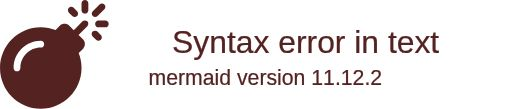

In [4]:
pipeline = RetrievalWorkflow()
pipeline.visualize_graph()

